In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline

In [2]:
import networkx as nx

In [3]:
from os.path import join

In [4]:
df = pd.read_csv("../data/crime.csv", parse_dates=["date"])

In [5]:
df.head()

,year,date,lat,lon,news,cassualties,url,neighborhood,mun_name,area
0,2015,2015-10-12,25.617672,-100.259318,Persiguen y ejecutan a hombre,1.0,http://www.elnorte.com/aplicaciones/articulo/d...,EJIDAL LOS REMATES,MONTERREY,0.000042
1,2015,2015-10-02,25.632075,-100.286088,Ejecutan a uno en plaza en Garza Sada,1.0,http://www.elnorte.com/aplicaciones/articulo/d...,REVOLUCION PROLETARIA,MONTERREY,0.000009
2,2015,2015-10-01,25.675784,-100.475788,Lo ejecutan frente a su casa,1.0,http://www.elnorte.com/aplicaciones/articulo/d...,HDA SANTA CATARINA (FOMERREY 29),SANTA CATARINA,0.000023
3,2015,2015-09-24,25.657586,-100.322029,Lo esperan para ejecutarlo,1.0,http://www.elnorte.com/aplicaciones/articulo/d...,INDEPENDENCIA,MONTERREY,0.000222
4,2015,2015-09-24,25.683207,-100.305650,Matan a 2 clientes en ataque 13 a bar,2.0,http://www.elnorte.com/aplicaciones/articulo/d...,CENTRO DE MONTERREY,MONTERREY,0.000717


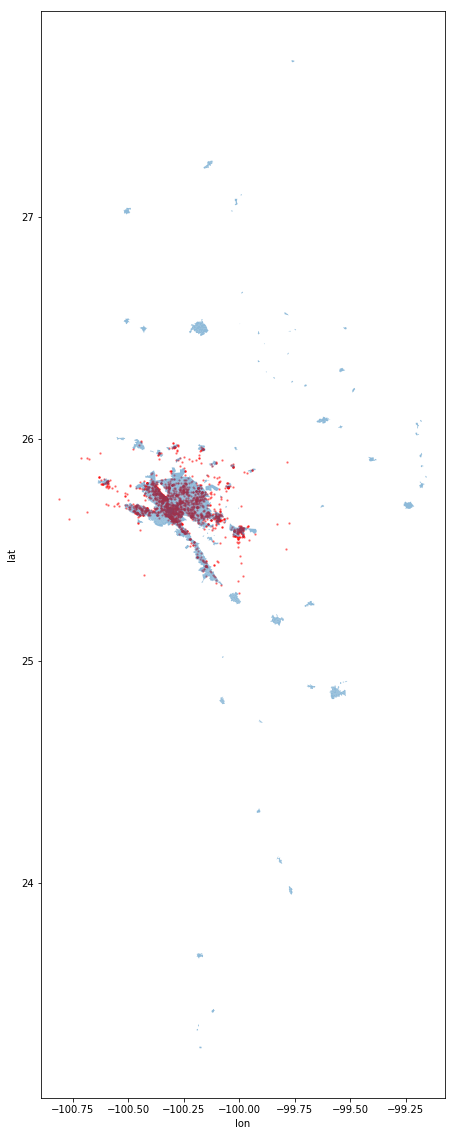

In [6]:
PATH = "/home/diana/Workspace/PhD/chuchocentro/shape"

fp = join(PATH, 'nuevo_leon.shp')

map_df = gpd.read_file(fp, encoding='latin')
fig, ax = plt.subplots(figsize=(20, 20))
scatter = df.plot.scatter(x='lon', y='lat', ax=ax, alpha=0.4, c='Red', s = 2)

map_df.plot(ax=ax, alpha=0.5)

In [7]:
vecinos = []
for index, colonia in map_df.iterrows():   
    # get 'not disjoint' countries
    neighbors = map_df[~map_df.geometry.disjoint(colonia.geometry)].OBJECTID.tolist()
    # remove own name from the list
    vecinos = vecinos + [(colonia.OBJECTID, name) 
                 for name in neighbors if colonia.OBJECTID != name ]

In [8]:
vecinos =  pd.DataFrame(vecinos, columns = ["source", "target"])
vecinos.to_csv("../data/adjacent_neighborhoods.csv", index = False)

In [67]:
map_df["x_center"] = map_df['geometry'].centroid.x
map_df["y_center"] = map_df['geometry'].centroid.y
map_df["centroid"] = map_df['geometry'].centroid.apply(lambda p: (p.x, p.y))

In [68]:
nodeData = map_df[["OBJECTID", "SETT_NAME", "POSTALCODE", "MUN_NAME", 
                   "SETT_TYPE", "x_center", "y_center",
                   "centroid"]].set_index("OBJECTID").to_dict('index')

In [69]:
G = nx.from_pandas_edgelist(vecinos)
G.add_nodes_from(map_df.OBJECTID)
nx.set_node_attributes(G, nodeData)

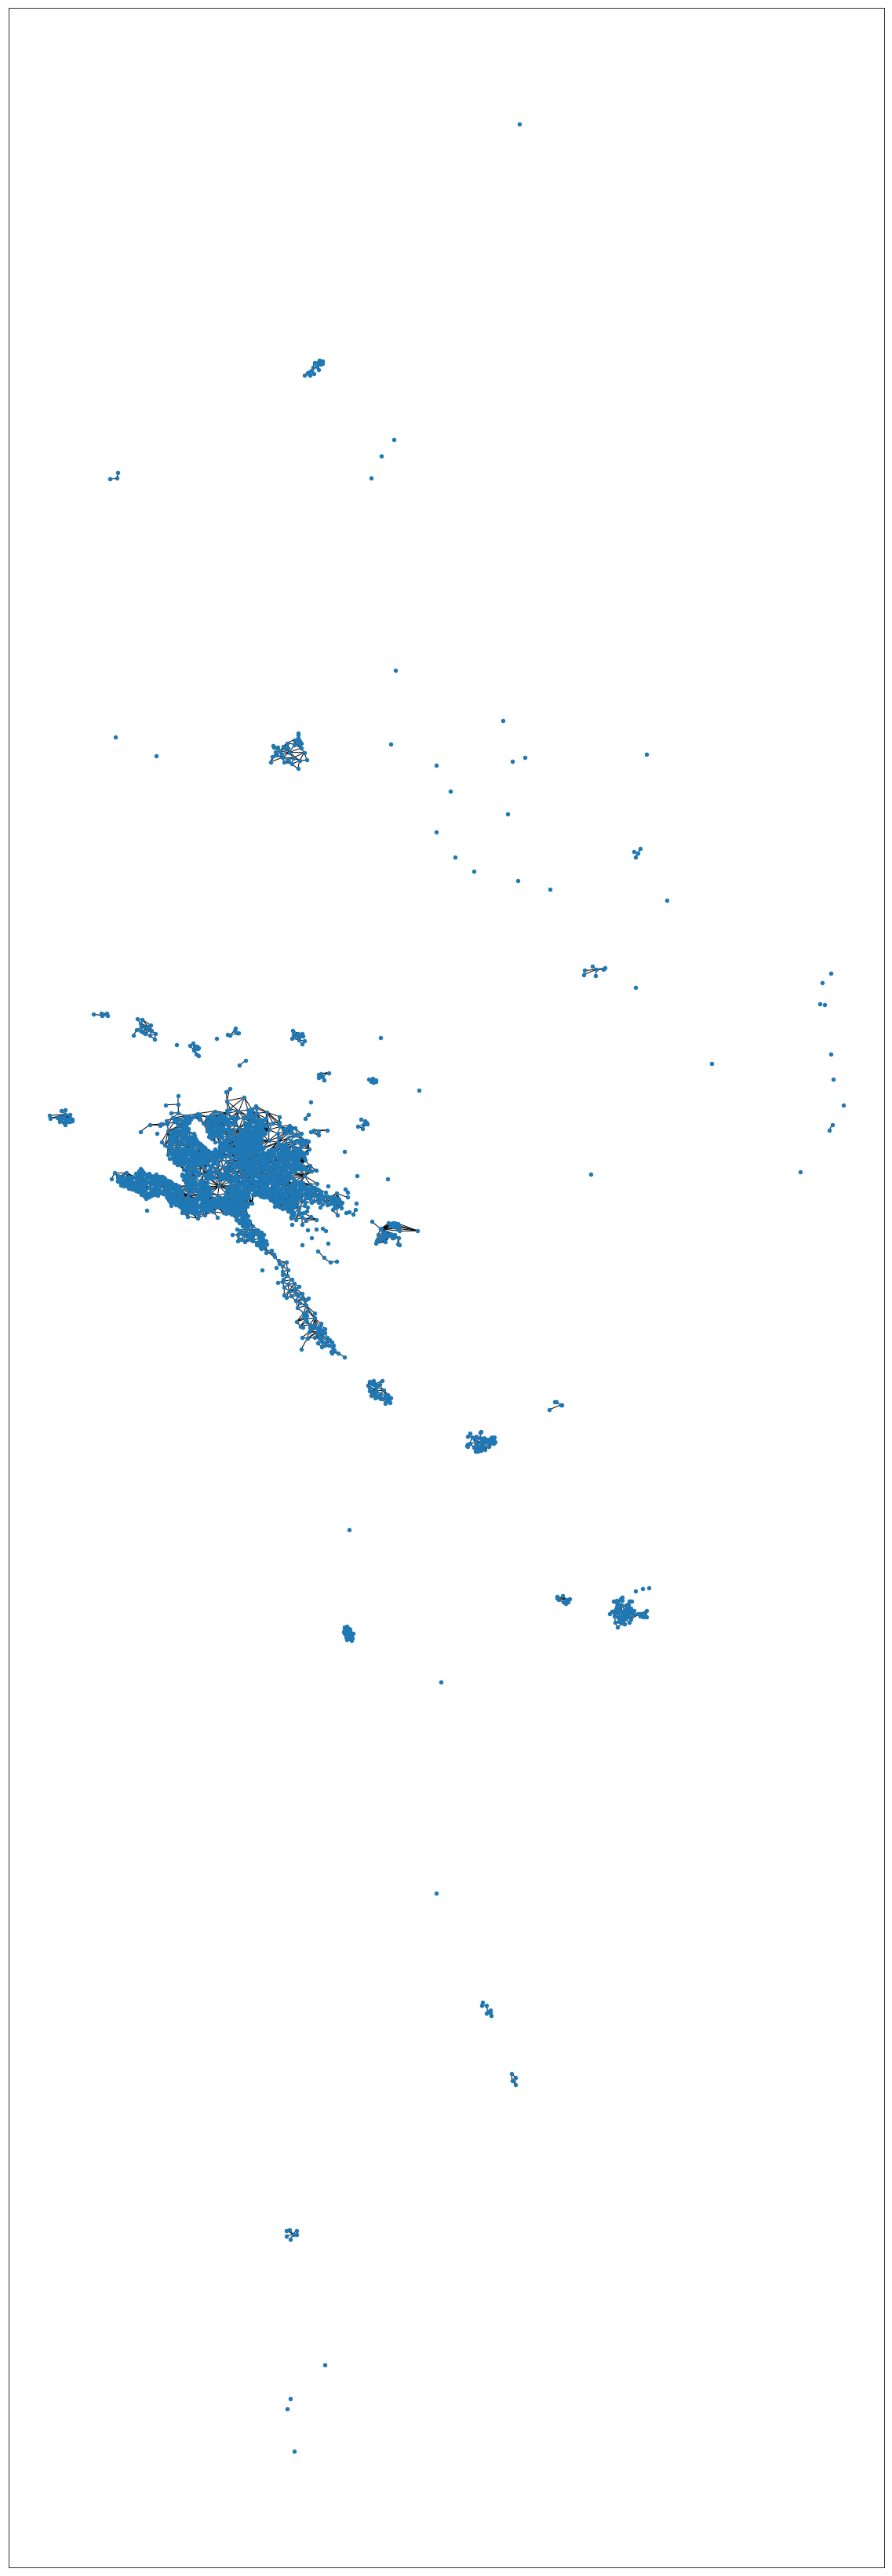

In [77]:
plt.figure(figsize=(20, 60))
pos = nx.get_node_attributes(G, "centroid")
nx.draw_networkx(G, pos = pos, with_labels = False, node_size = 20)

### We need to map again because there are duplicate neighborhoods 

In [15]:
df = df[['year', 'date', 'lat', 'lon', 'news', 'cassualties', 'url', 'area']]

In [17]:
from shapely.geometry import Point, Polygon

In [18]:
neighborhoods = []
for i, row in df.iterrows():
    p = Point(row['lon'], row['lat'])
    for j, row_j in map_df.iterrows():
        polygon = row_j['geometry']
        if p.within(polygon):
            neighborhoods.append(row_j['OBJECTID'])
            break
    else:
        neighborhoods.append(np.nan)

In [31]:
neighborhoods = pd.Series(neighborhoods).fillna(0).astype(int).tolist()

In [32]:
df["OBJECTID"] = neighborhoods

In [45]:
df = df.merge(map_df, on = "OBJECTID", how = "left")  

In [48]:
df = df[['year', 'date', 'lat', 'lon', 'news', 'cassualties', 'url', 'area',
       'OBJECTID', 'POSTALCODE','MUN_NAME', 'SETT_NAME', 'SETT_TYPE']]

In [84]:
map_df.drop("centroid", axis= 1).to_file("../shape/nuevo_leon_2.shp")

In [88]:
df.to_csv("../data/crime.csv", index = False,  encoding='latin')